In [ ]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandana

Collect the spatial boundary and street network:

In [2]:
boundary_gdf = gpd.read_file('New York.geojson').to_crs(epsg=4326)
street_network = ox.graph_from_polygon(boundary_gdf.geometry[0], network_type='all')

Get nodes and edges:

In [ ]:
nodes, edges = ox.graph_to_gdfs(street_network)

Create a pandana network:

In [4]:
#Nodes:
nodes_gdf = nodes.reset_index()
osmid_mapping = {v:k for k, v in nodes_gdf.osmid.to_dict().items()}

#Edges:
edges_gdf = edges.reset_index()
edges_gdf['u'] = edges_gdf['u'].map(osmid_mapping)
edges_gdf['v'] = edges_gdf['v'].map(osmid_mapping)

#Graph:
pandanda_graph = pandana.Network(nodes_gdf['x'], nodes_gdf['y'],
                                 edges_gdf['u'], edges_gdf['v'], edges_gdf[['length']])

Generating contraction hierarchies with 32 threads.
Setting CH node vector of size 439713
Setting CH edge vector of size 1345403
Range graph removed 1235350 edges of 2690806
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


Precompute queries:

In [5]:
pandanda_graph.precompute(5_000)

Collect the subway data:

In [13]:
subway_entrances = gpd.read_file('MTA_entrances.geojson').to_crs(epsg=4326)
subway_entrances_gdf = subway_entrances[subway_entrances['entry_allowed'] == 'YES'].dropna(subset=['geometry']).reset_index(drop=True)

Collect the Subway data:

In [14]:
restaurants_gdf = gpd.read_file('restaurants.geojson').to_crs(epsg=4326)
subway_gdf = restaurants_gdf[restaurants_gdf.dba == 'SUBWAY'].sort_values(['camis', 'inspection_date'], ascending=False).dropna(subset=['geometry']).drop_duplicates(subset=['camis'], keep='first').reset_index(drop=True)

Set POIs:

In [17]:
pandanda_graph.set_pois('restaurants', maxdist=10_000, maxitems=2, x_col=subway_gdf.geometry.x, y_col=subway_gdf.geometry.y)
pandanda_graph.set_pois('mta',         maxdist=10_000, maxitems=2, x_col=subway_entrances_gdf.geometry.x, y_col=subway_entrances_gdf.geometry.y)

Compute distance to nearest POI of each type per node:

In [ ]:
dist_to_rest = pandanda_graph.nearest_pois(10_000, 'restaurants', num_pois=1, max_distance=100_000, include_poi_ids=False)[1]
dist_to_mta  = pandanda_graph.nearest_pois(10_000, 'mta',         num_pois=1, max_distance=100_000, include_poi_ids=False)[1]

#Clean:
valid_points = (dist_to_rest < 100_000) & (dist_to_mta < 100_000)
dist_to_rest[~valid_points] = np.nan
dist_to_mta[~valid_points]  = np.nan

#Map to nodes:
nodes_gdf['MTA'] = dist_to_mta
nodes_gdf['SUBWAY'] = dist_to_rest

Aggregate per Census Block:

In [56]:
#Collect the Census Blocks:
cb_gdf = gpd.read_file('2020_Census_Blocks.geojson').to_crs(epsg=4326)[['geometry', 'geoid']].set_index('geoid')

#Project:
cb_proj = cb_gdf.to_crs('EPSG:32118')
pt_proj = nodes_gdf[['geometry', 'MTA', 'SUBWAY']].to_crs('EPSG:32118')

#Join:
joined_data = gpd.sjoin(pt_proj, cb_proj, how='inner', predicate='within')
average_distance = joined_data.groupby('geoid').agg({'MTA':'mean', 'SUBWAY':'mean'})
average_distance_gdf = gpd.GeoDataFrame(average_distance, geometry=cb_gdf.loc[average_distance.index].geometry)

#Compute the ratio:
average_distance_gdf['ratio'] = average_distance_gdf['MTA']/average_distance_gdf['SUBWAY']
average_distance_gdf.loc[average_distance_gdf['MTA'] == 0, 'ratio'] = 0.
average_distance_gdf.loc[average_distance_gdf['SUBWAY'] == 0, 'ratio'] = np.inf
average_distance_gdf.loc[average_distance_gdf['SUBWAY'].isna()|average_distance_gdf['MTA'].isna(), 'ratio'] = np.nan
average_distance_gdf.loc[average_distance_gdf['MTA'] == average_distance_gdf['SUBWAY'], 'ratio'] = 1.

Map:

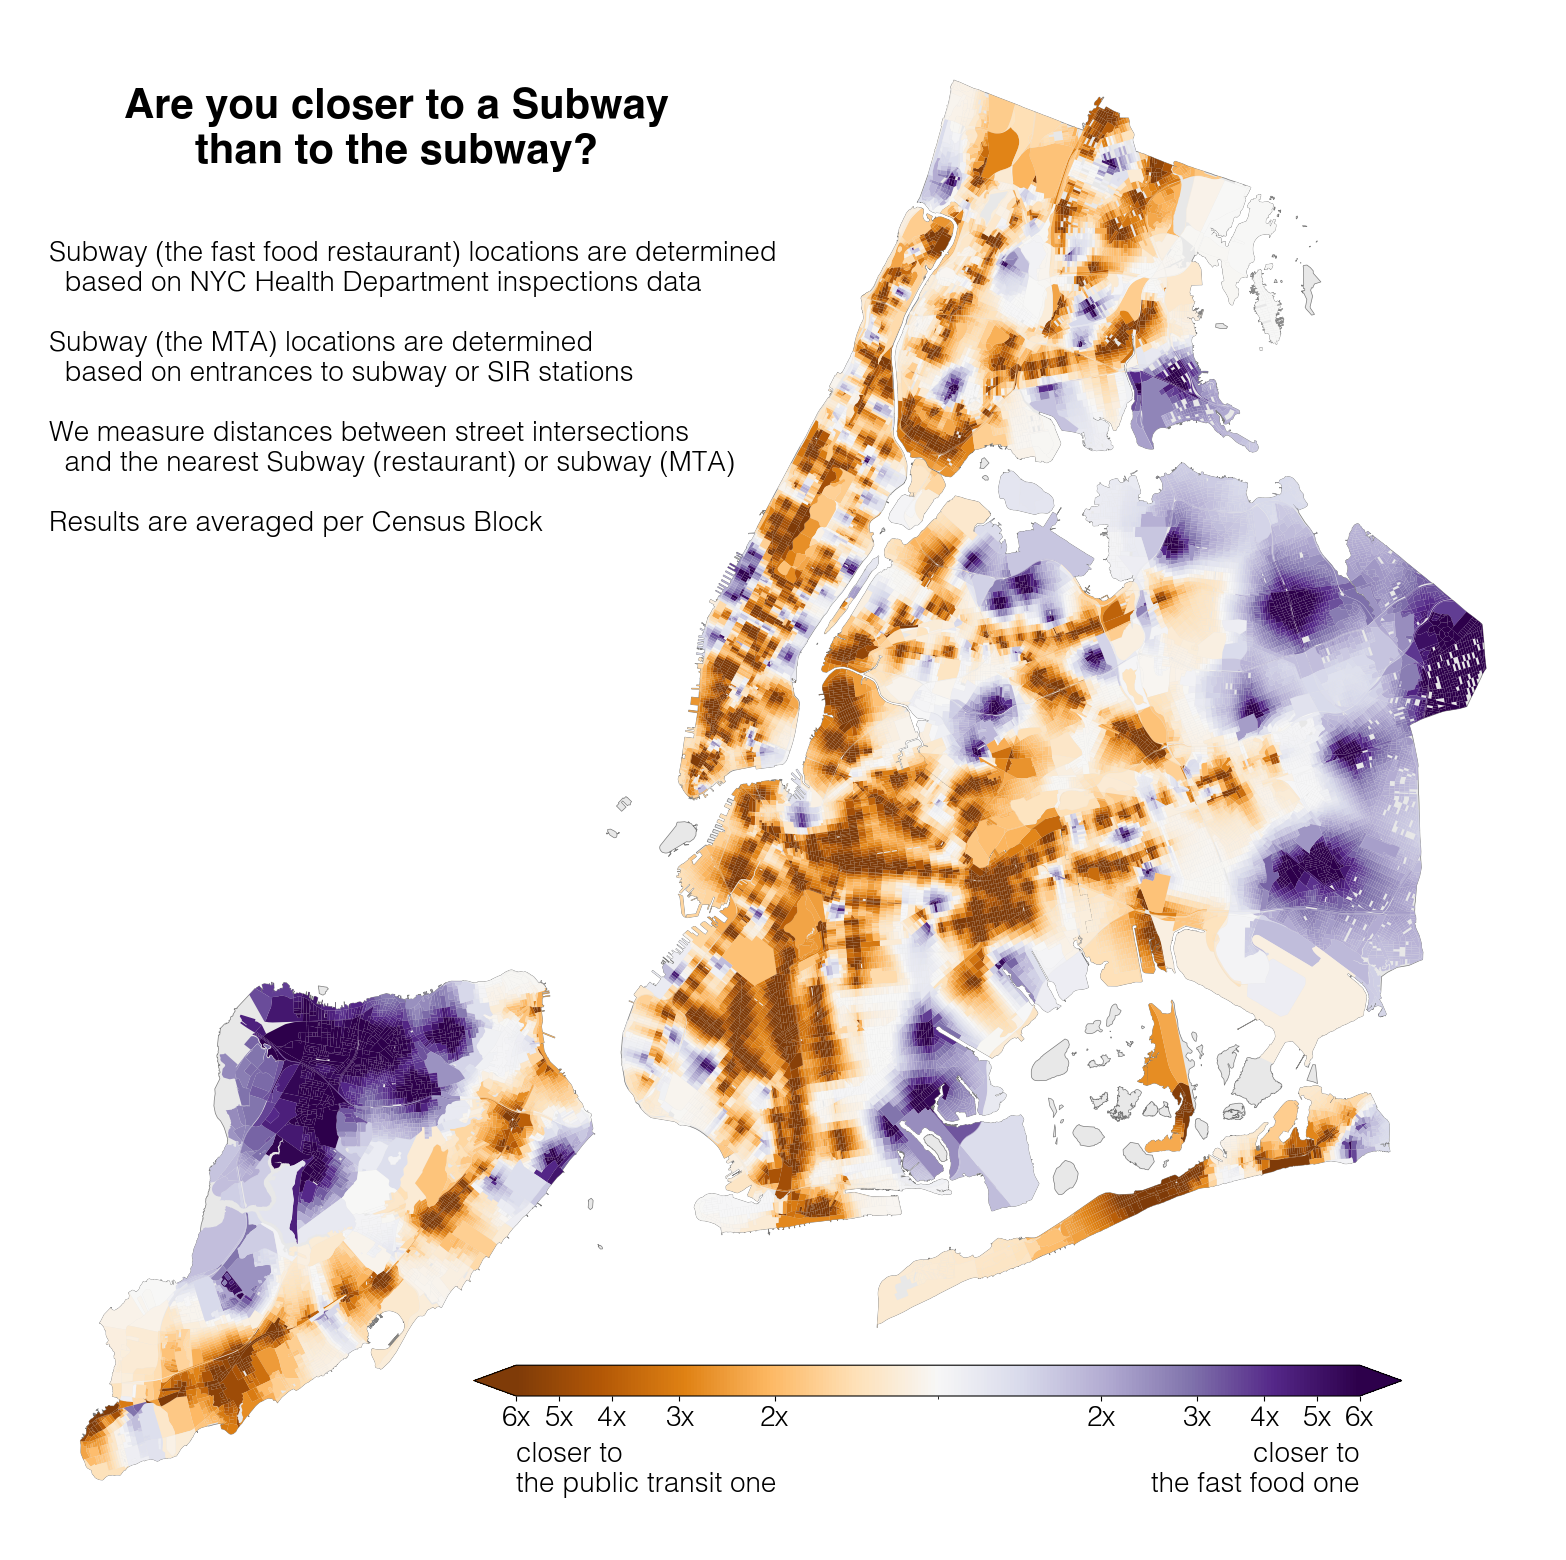

In [98]:
fig, ax = plt.subplots(figsize=(20, 20))

max_ratio = 6

#Plot base boundary
_ = boundary_gdf.plot(color='lightgrey', ax=ax, alpha=0.5, linewidth=0.5, edgecolor='k')

#Clip ratios
ratio = average_distance_gdf['ratio'].clip(lower=1/max_ratio, upper=max_ratio)

#Define a diverging colormap and symmetric log normalization
norm = mcolors.SymLogNorm(linthresh=0.001, linscale=0.01, vmin=1/max_ratio, vmax=max_ratio, base=20)
cmap = plt.cm.PuOr

#Plot data
_ = average_distance_gdf.plot(column=ratio, cmap=cmap, norm=norm, ax=ax, linewidth=0)

#Add colorbar:
cbar_ax = ax.inset_axes([0.3, 0.1, 0.6, 0.02])  # [left, bottom, width, height]
cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal', extend='both')

#Define tick positions and labels (logarithmic spacing)
_ = cb.set_ticks([1/x for x in range(2, max_ratio+1)][::-1] + [x for x in range(2, max_ratio+1)])
ticks = [f'{x}x' for x in range(2, max_ratio+1)]
_ = cb.set_ticklabels(ticks[::-1] + ticks)
_ = cb.ax.tick_params(labelsize=20)

# Annotate below colorbar
_ = cbar_ax.text(0.0, -1.5, "closer to\nthe public transit one", ha='left', va='top', fontsize=20, transform=cbar_ax.transAxes)
_ = cbar_ax.text(1.0, -1.5, "closer to\nthe fast food one", ha='right', va='top', fontsize=20, transform=cbar_ax.transAxes)

#Title:
_ = ax.text(0.25, 0.95, 'Are you closer to a Subway\nthan to the subway?', fontsize=30, weight='bold', ha='center', va='top', transform=ax.transAxes)
desc = (
    "Subway (the fast food restaurant) locations are determined\n"
    "  based on NYC Health Department inspections data\n\n"
    "Subway (the MTA) locations are determined\n"
    "  based on entrances to subway or SIR stations\n\n"
    "We measure distances between street intersections\n"
    "  and the nearest Subway (restaurant) or subway (MTA)\n\n"
    "Results are averaged per Census Block"
)
_ = ax.text(0.025, 0.85, desc,
            fontsize=20, ha='left', va='top', transform=ax.transAxes)


# Tidy up
_ = ax.set_axis_off()
plt.savefig('subways_puor.png', dpi=300, bbox_inches='tight')
plt.show()

